# MLP
Like MLP_269 but run on every cell line individually.

In [25]:

from datetime import datetime
print(datetime.now())

2023-04-19 18:19:41.738879


In [26]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [27]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
# EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_276'

Python 3.9.16
sklearn 1.2.2


In [28]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [29]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
CELL_LINES=[14]  # just IMR.90

## Data Load

In [30]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    string = fields[cell_line]
                    if string != 'nan':
                        value = float(string)
                        self.gene2rci[gene_id] = value
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [31]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [32]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-19 18:19:42.926846
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 128)               131328    
                                                                 
 dense_57 (Dense)            (None, 64)                8256      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_58 (Dense)            (None, 64)                4160      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 1)                 65        
                                                                 
Total params: 143,809
Trai

## Training

In [33]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd)  # no validation )
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [34]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

In [35]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)




2023-04-19 18:19:43.154369
Cell Line 14 IMR.90
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 441
Num RCI: 441
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 441 sequences.

Training # 1 1
2023-04-19 18:19:44.061826
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-19 18:19:44.069055
Discriminator is GMM
Means [-2.63411804077769, 0.5585074568195904]
Variances [3.47674223 1.46919005]
Priors [0.37957452 0.62042548]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 233:115 66.95%
Computed class weights: {0: 1.5130434782608695, 1: 0.7467811158798283}
Valid 1:0 54:39 58.06%
FIT
2023-04-19 18:19:44.824893


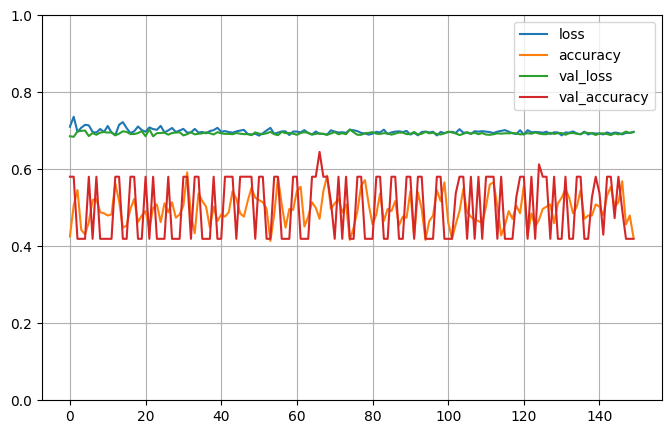


Testing # 1 1
2023-04-19 18:20:06.721405
2023-04-19 18:20:06.722452
PREDICT
2023-04-19 18:20:06.724653
Test 1:0 54:39 58.06%
Predict 1:0 0:93  0.00%
Test sizes (93, 1025) (93,)
Distrib of scores: 0.4889077 mean 0.00080409646 std
Range of scores: 0.4873029 to 0.49088758
Score threshold 0.5
Confusion matrix
 [[39  0]
 [54  0]]
Normalized matrix
 [[0.41935484 0.        ]
 [0.58064516 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


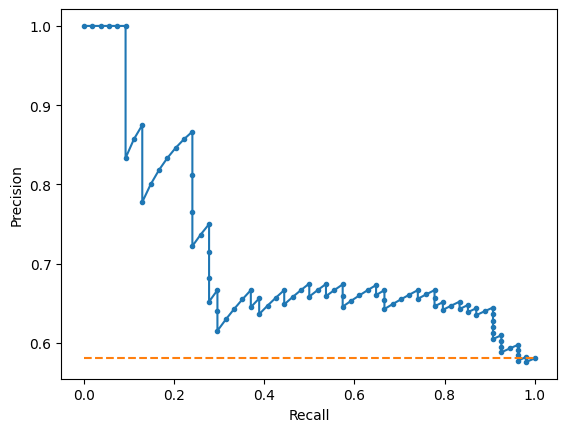

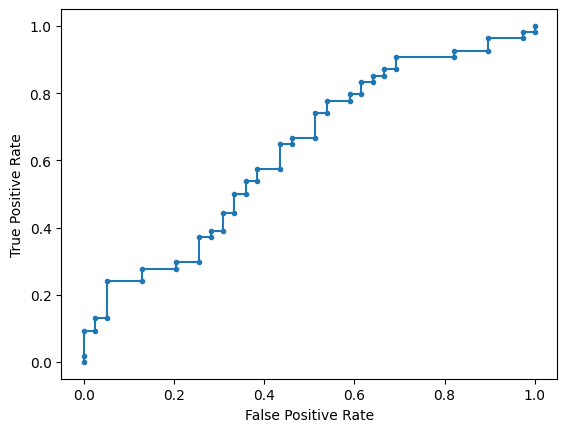

Accuracy: 41.94% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 71.03% AUROC: 63.01%
 accuracy [41.935483870967744]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [71.02804321547224]
 AUROC [63.01044634377968]

Training # 1 2
2023-04-19 18:20:07.760498
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-19 18:20:07.774035
Discriminator is GMM
Means [0.5243892143435377, -2.717728242240844]
Variances [1.42739134 2.53589381]
Priors [0.61391257 0.38608743]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 227:123 64.86%
Computed class weights: {0: 1.4227642276422765, 1: 0.7709251101321586}
Valid 1:0 59:32 64.84%
FIT
2023-04-19 18:20:08.310226


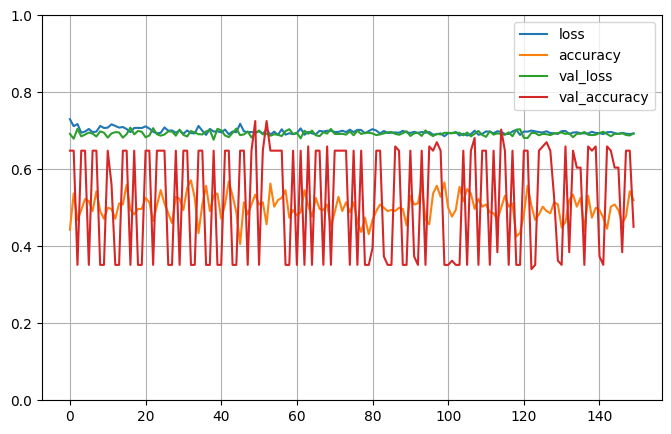


Testing # 1 2
2023-04-19 18:20:30.449445
2023-04-19 18:20:30.449989
PREDICT
2023-04-19 18:20:30.457686
Test 1:0 59:32 64.84%
Predict 1:0 15:76 16.48%
Test sizes (91, 1025) (91,)
Distrib of scores: 0.49768716 mean 0.0023800267 std
Range of scores: 0.49251714 to 0.50432307
Score threshold 0.5
Confusion matrix
 [[29  3]
 [47 12]]
Normalized matrix
 [[0.31868132 0.03296703]
 [0.51648352 0.13186813]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


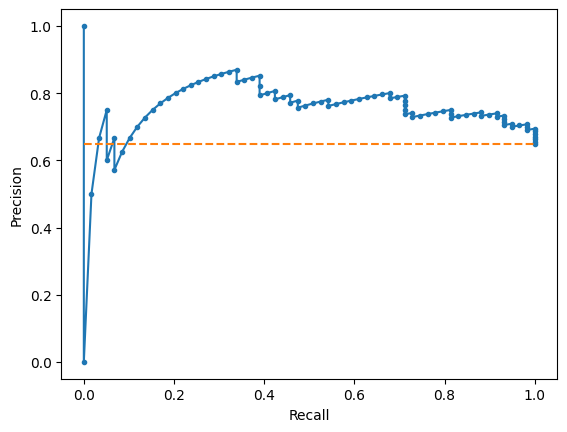

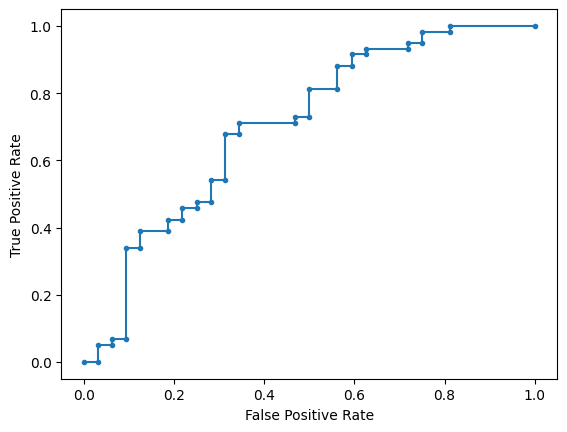

Accuracy: 45.05% Precision: 80.00% Recall: 20.34%
F1: 32.43% MCC: 0.1411
AUPRC: 75.22% AUROC: 70.39%
 accuracy [45.05494505494506]
 precision [80.0]
 recall [20.33898305084746]
 F1 [32.43243243243243]
 MCC [0.14109672219219307]
 AUPRC [75.21731080258022]
 AUROC [70.39194915254237]

Training # 1 3
2023-04-19 18:20:31.380118
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-19 18:20:31.396805
Discriminator is GMM
Means [-2.6208451918813767, 0.6316052011578442]
Variances [3.50975702 1.42984643]
Priors [0.41458992 0.58541008]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 222:139 61.50%
Computed class weights: {0: 1.2985611510791366, 1: 0.8130630630630631}
Valid 1:0 51:29 63.75%
FIT
2023-04-19 18:20:33.299921


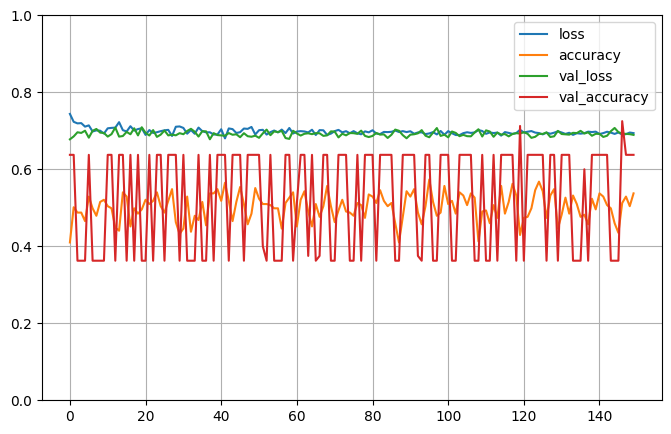


Testing # 1 3
2023-04-19 18:20:56.212079
2023-04-19 18:20:56.212237
PREDICT
2023-04-19 18:20:56.218571
Test 1:0 51:29 63.75%
Predict 1:0 80:0 100.00%
Test sizes (80, 1025) (80,)
Distrib of scores: 0.50636005 mean 0.0005850569 std
Range of scores: 0.5051802 to 0.50854635
Score threshold 0.5
Confusion matrix
 [[ 0 29]
 [ 0 51]]
Normalized matrix
 [[0.     0.3625]
 [0.     0.6375]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


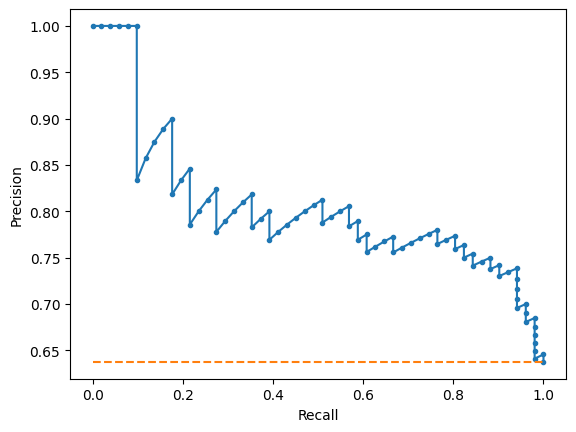

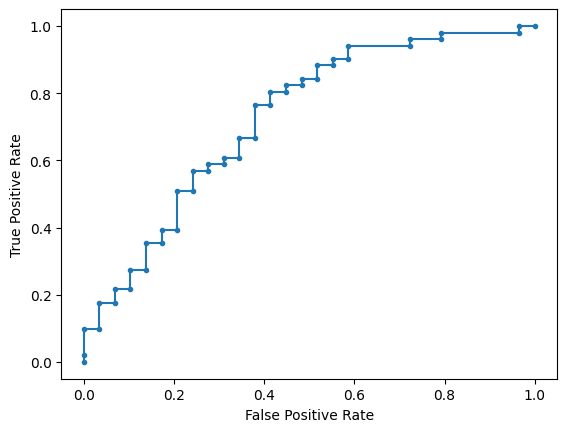

Accuracy: 63.75% Precision: 63.75% Recall: 100.00%
F1: 77.86% MCC: 0.0000
AUPRC: 80.32% AUROC: 72.62%
 accuracy [63.74999999999999]
 precision [63.74999999999999]
 recall [100.0]
 F1 [77.86259541984732]
 MCC [0.0]
 AUPRC [80.32217736176386]
 AUROC [72.61663286004057]

Training # 1 4
2023-04-19 18:20:56.931963
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-19 18:20:56.952149
Discriminator is GMM
Means [0.409028012902644, -2.8652184346349348]
Variances [1.51805034 3.235395  ]
Priors [0.63895608 0.36104392]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 235:109 68.31%
Computed class weights: {0: 1.5779816513761469, 1: 0.7319148936170212}
Valid 1:0 67:30 69.07%
FIT
2023-04-19 18:20:57.843488


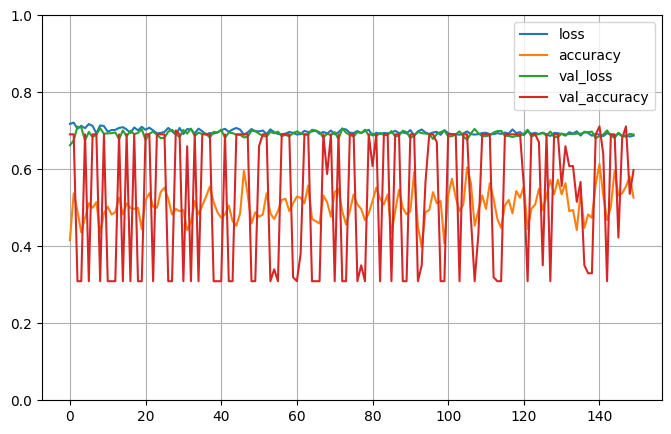


Testing # 1 4
2023-04-19 18:21:21.011374
2023-04-19 18:21:21.011453
PREDICT
2023-04-19 18:21:21.014137
Test 1:0 67:30 69.07%
Predict 1:0 44:53 45.36%
Test sizes (97, 1025) (97,)
Distrib of scores: 0.50005466 mean 0.006056629 std
Range of scores: 0.48959574 to 0.51752603
Score threshold 0.5
Confusion matrix
 [[22  8]
 [31 36]]
Normalized matrix
 [[0.22680412 0.08247423]
 [0.31958763 0.37113402]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


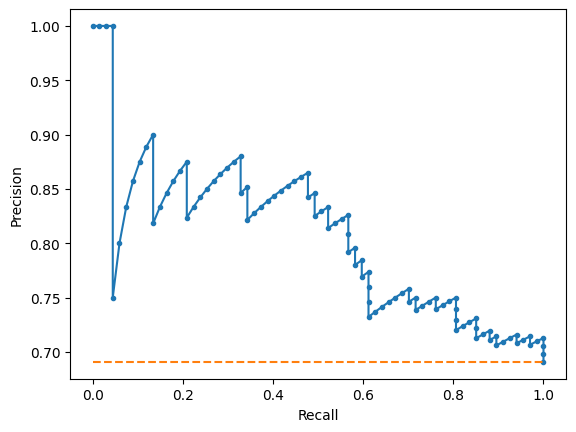

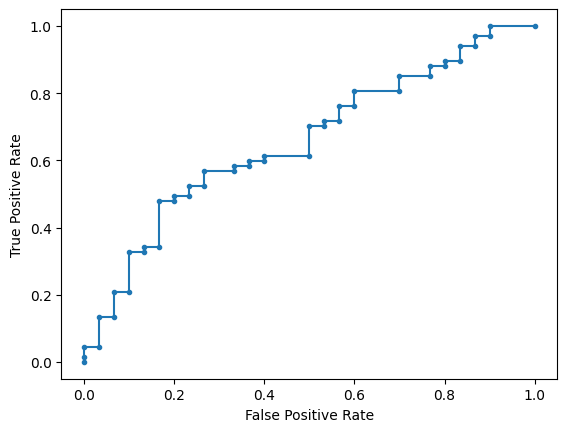

Accuracy: 59.79% Precision: 81.82% Recall: 53.73%
F1: 64.86% MCC: 0.2513
AUPRC: 80.48% AUROC: 65.62%
 accuracy [59.79381443298969]
 precision [81.81818181818183]
 recall [53.73134328358209]
 F1 [64.86486486486487]
 MCC [0.2512676615367412]
 AUPRC [80.47864668236303]
 AUROC [65.62189054726369]

Training # 1 5
2023-04-19 18:21:21.702124
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-19 18:21:21.716436
Discriminator is GMM
Means [-2.4877416112229764, 0.6387406958166012]
Variances [3.36592589 1.33100701]
Priors [0.43516766 0.56483234]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 214:147 59.28%
Computed class weights: {0: 1.227891156462585, 1: 0.8434579439252337}
Valid 1:0 53:27 66.25%
FIT
2023-04-19 18:21:22.397092


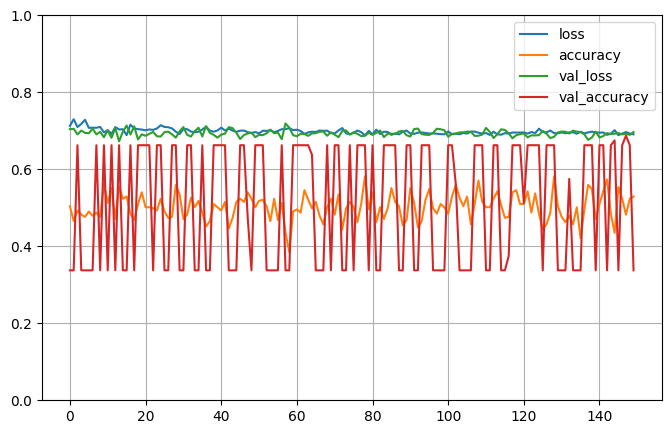


Testing # 1 5
2023-04-19 18:21:47.670544
2023-04-19 18:21:47.670995
PREDICT
2023-04-19 18:21:47.673071
Test 1:0 53:27 66.25%
Predict 1:0 0:80  0.00%
Test sizes (80, 1025) (80,)
Distrib of scores: 0.49424943 mean 0.0005370058 std
Range of scores: 0.49305415 to 0.49579048
Score threshold 0.5
Confusion matrix
 [[27  0]
 [53  0]]
Normalized matrix
 [[0.3375 0.    ]
 [0.6625 0.    ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


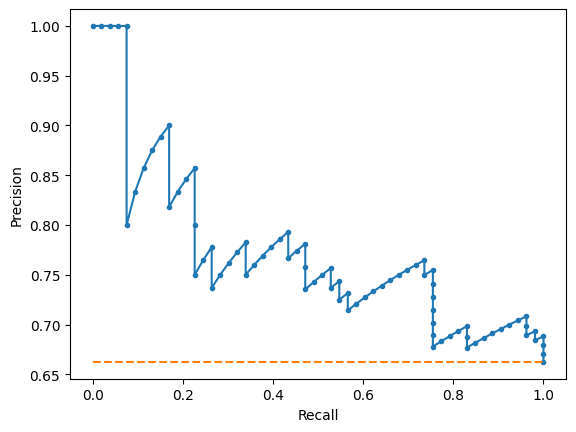

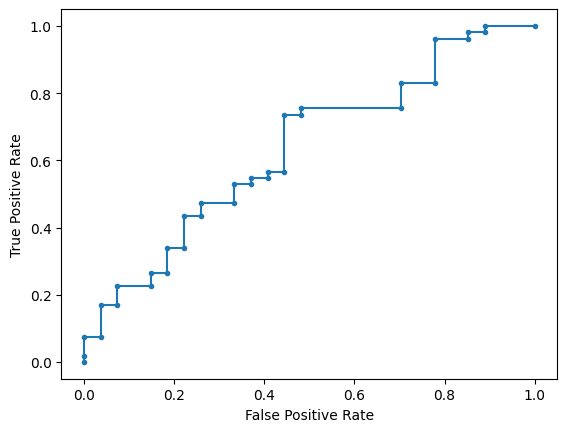

Accuracy: 33.75% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 77.21% AUROC: 63.52%
 accuracy [33.75]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [77.20723573608308]
 AUROC [63.52201257861636]

Training # 2 1
2023-04-19 18:21:48.282038
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-19 18:21:48.295221
Discriminator is GMM
Means [0.5734610253045949, -2.5678109585575766]
Variances [1.40925418 3.27656158]
Priors [0.58275163 0.41724837]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 219:137 61.52%
Computed class weights: {0: 1.2992700729927007, 1: 0.8127853881278538}
Valid 1:0 55:30 64.71%
FIT
2023-04-19 18:21:48.900524


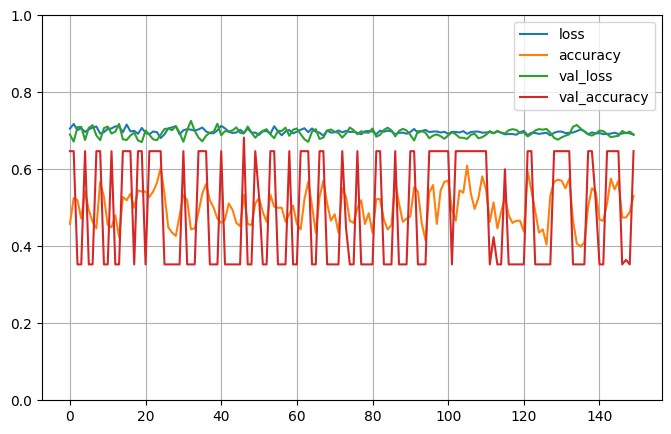


Testing # 2 1
2023-04-19 18:22:07.480570
2023-04-19 18:22:07.480626
PREDICT
2023-04-19 18:22:07.482512
Test 1:0 55:30 64.71%
Predict 1:0 85:0 100.00%
Test sizes (85, 1025) (85,)
Distrib of scores: 0.50532407 mean 0.0008962917 std
Range of scores: 0.50344825 to 0.50733095
Score threshold 0.5
Confusion matrix
 [[ 0 30]
 [ 0 55]]
Normalized matrix
 [[0.         0.35294118]
 [0.         0.64705882]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


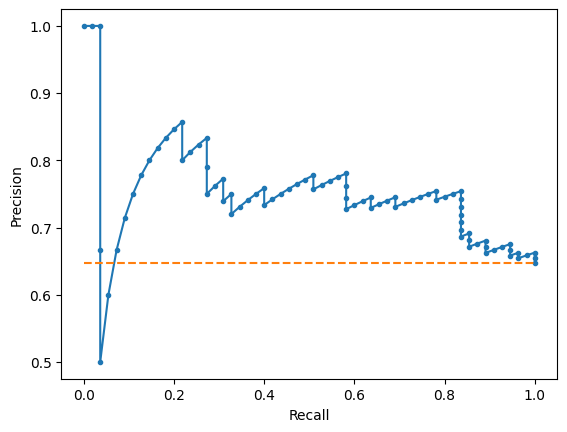

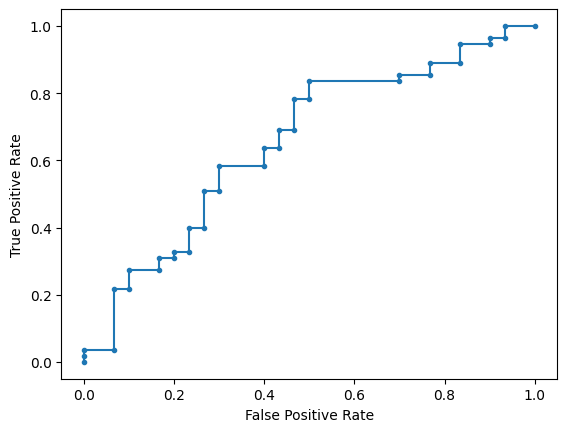

Accuracy: 64.71% Precision: 64.71% Recall: 100.00%
F1: 78.57% MCC: 0.0000
AUPRC: 74.88% AUROC: 65.33%
 accuracy [64.70588235294117]
 precision [64.70588235294117]
 recall [100.0]
 F1 [78.57142857142858]
 MCC [0.0]
 AUPRC [74.88489510380063]
 AUROC [65.33333333333333]

Training # 2 2
2023-04-19 18:22:08.049170
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-19 18:22:08.066046
Discriminator is GMM
Means [0.5686141777802556, -2.5664409288812995]
Variances [1.47950125 3.04077848]
Priors [0.60762394 0.39237606]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 229:125 64.69%
Computed class weights: {0: 1.416, 1: 0.7729257641921398}
Valid 1:0 52:35 59.77%
FIT
2023-04-19 18:22:08.709033


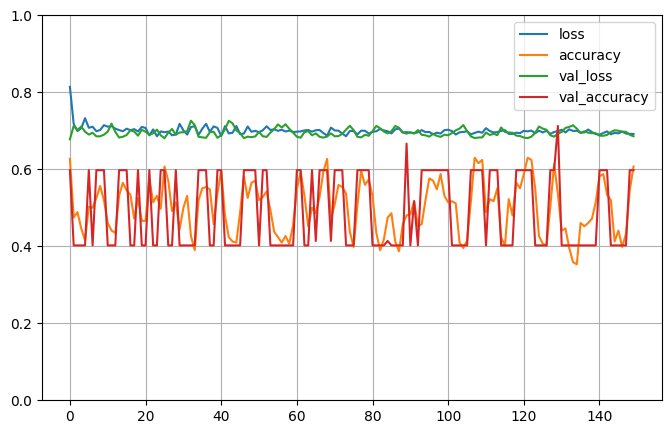


Testing # 2 2
2023-04-19 18:22:28.910051
2023-04-19 18:22:28.910455
PREDICT
2023-04-19 18:22:28.918214
Test 1:0 52:35 59.77%
Predict 1:0 87:0 100.00%
Test sizes (87, 1025) (87,)
Distrib of scores: 0.5203508 mean 0.00048460436 std
Range of scores: 0.5194154 to 0.5220889
Score threshold 0.5
Confusion matrix
 [[ 0 35]
 [ 0 52]]
Normalized matrix
 [[0.         0.40229885]
 [0.         0.59770115]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


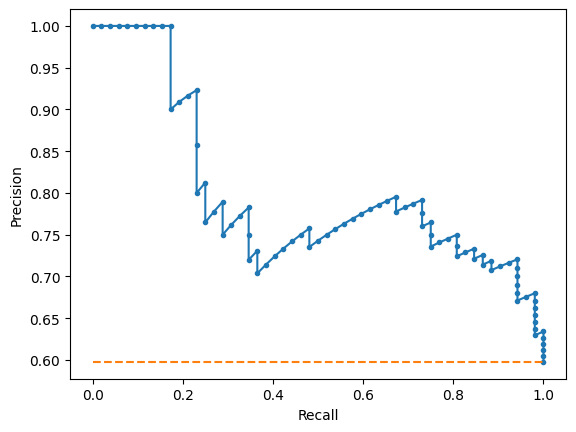

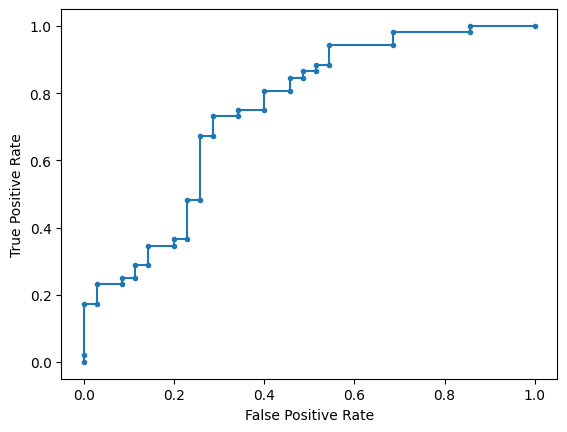

Accuracy: 59.77% Precision: 59.77% Recall: 100.00%
F1: 74.82% MCC: 0.0000
AUPRC: 79.94% AUROC: 74.73%
 accuracy [59.77011494252874]
 precision [59.77011494252874]
 recall [100.0]
 F1 [74.82014388489209]
 MCC [0.0]
 AUPRC [79.93820513732256]
 AUROC [74.72527472527473]

Training # 2 3
2023-04-19 18:22:29.652066
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-19 18:22:29.659539
Discriminator is GMM
Means [-2.69764608147578, 0.48009186864617753]
Variances [3.24368989 1.5414928 ]
Priors [0.39777531 0.60222469]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 229:130 63.79%
Computed class weights: {0: 1.3807692307692307, 1: 0.7838427947598253}
Valid 1:0 59:23 71.95%
FIT
2023-04-19 18:22:30.327032


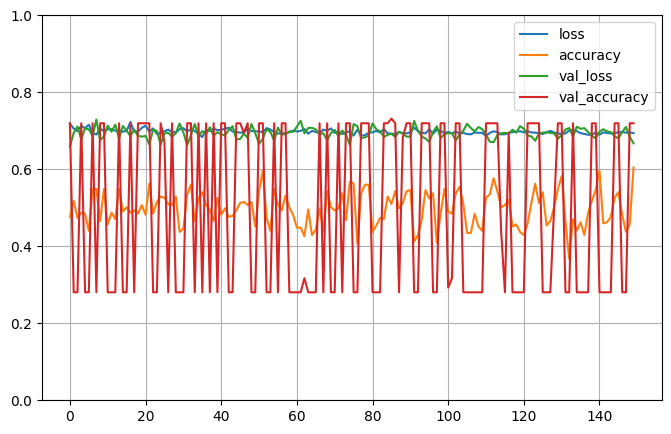


Testing # 2 3
2023-04-19 18:22:52.371172
2023-04-19 18:22:52.371656
PREDICT
2023-04-19 18:22:52.383453
Test 1:0 59:23 71.95%
Predict 1:0 82:0 100.00%
Test sizes (82, 1025) (82,)
Distrib of scores: 0.53060055 mean 0.0010168381 std
Range of scores: 0.5282635 to 0.53262997
Score threshold 0.5
Confusion matrix
 [[ 0 23]
 [ 0 59]]
Normalized matrix
 [[0.        0.2804878]
 [0.        0.7195122]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


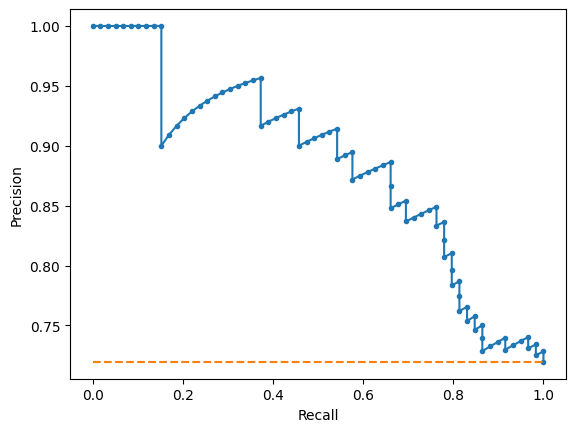

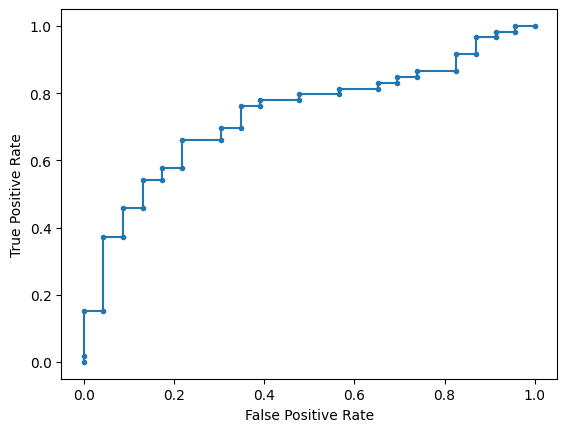

Accuracy: 71.95% Precision: 71.95% Recall: 100.00%
F1: 83.69% MCC: 0.0000
AUPRC: 88.38% AUROC: 73.62%
 accuracy [71.95121951219512]
 precision [71.95121951219512]
 recall [100.0]
 F1 [83.68794326241135]
 MCC [0.0]
 AUPRC [88.37849546055945]
 AUROC [73.61827560795872]

Training # 2 4
2023-04-19 18:22:53.056998
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-19 18:22:53.071251
Discriminator is GMM
Means [0.517409336486502, -2.7635470269218967]
Variances [1.46785891 3.40025343]
Priors [0.63607589 0.36392411]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 229:107 68.15%
Computed class weights: {0: 1.5700934579439252, 1: 0.7336244541484717}
Valid 1:0 63:42 60.00%
FIT
2023-04-19 18:22:56.608388


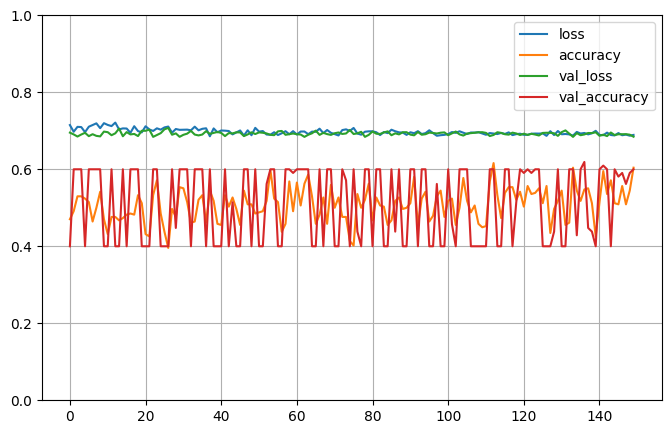


Testing # 2 4
2023-04-19 18:23:15.860303
2023-04-19 18:23:15.860357
PREDICT
2023-04-19 18:23:15.867294
Test 1:0 63:42 60.00%
Predict 1:0 105:0 100.00%
Test sizes (105, 1025) (105,)
Distrib of scores: 0.51864034 mean 0.004987853 std
Range of scores: 0.5086648 to 0.5308025
Score threshold 0.5
Confusion matrix
 [[ 0 42]
 [ 0 63]]
Normalized matrix
 [[0.  0.4]
 [0.  0.6]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


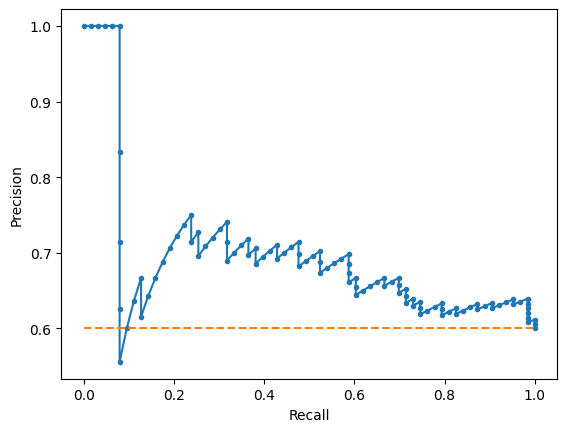

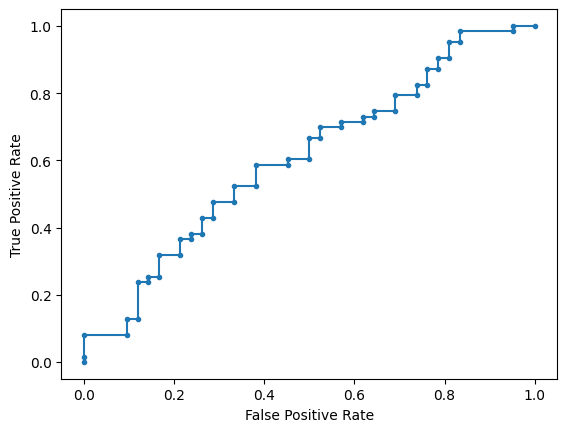

Accuracy: 60.00% Precision: 60.00% Recall: 100.00%
F1: 75.00% MCC: 0.0000
AUPRC: 69.36% AUROC: 60.70%
 accuracy [60.0]
 precision [60.0]
 recall [100.0]
 F1 [74.99999999999999]
 MCC [0.0]
 AUPRC [69.35590084934364]
 AUROC [60.695389266817834]

Training # 2 5
2023-04-19 18:23:16.510082
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-19 18:23:16.521840
Discriminator is GMM
Means [-2.658795181231708, 0.6302053607250955]
Variances [3.2985036  1.30186567]
Priors [0.4133596 0.5866404]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 219:140 61.00%
Computed class weights: {0: 1.2821428571428573, 1: 0.819634703196347}
Valid 1:0 51:31 62.20%
FIT
2023-04-19 18:23:17.137552


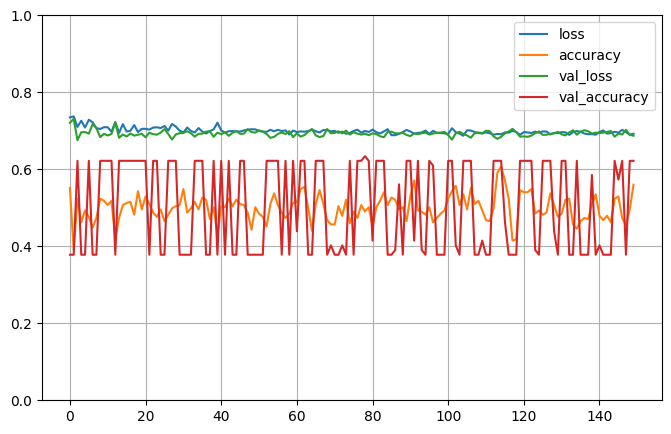


Testing # 2 5
2023-04-19 18:23:39.165107
2023-04-19 18:23:39.165298
PREDICT
2023-04-19 18:23:39.166766
Test 1:0 51:31 62.20%
Predict 1:0 82:0 100.00%
Test sizes (82, 1025) (82,)
Distrib of scores: 0.51192087 mean 0.0010674958 std
Range of scores: 0.5099655 to 0.51525545
Score threshold 0.5
Confusion matrix
 [[ 0 31]
 [ 0 51]]
Normalized matrix
 [[0.         0.37804878]
 [0.         0.62195122]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


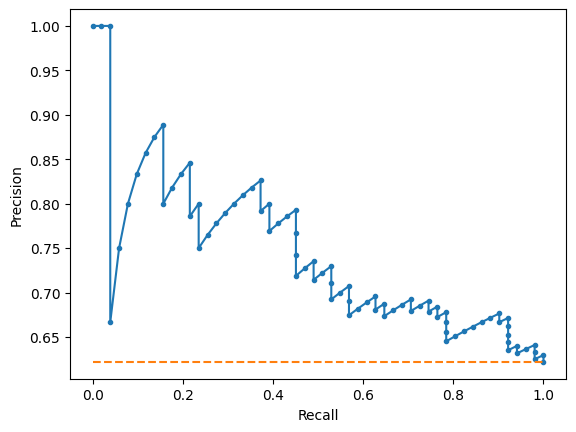

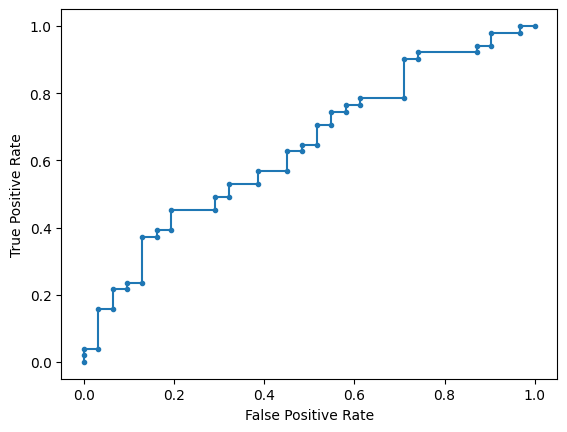

Accuracy: 62.20% Precision: 62.20% Recall: 100.00%
F1: 76.69% MCC: 0.0000
AUPRC: 74.19% AUROC: 63.82%
 accuracy [62.19512195121951]
 precision [62.19512195121951]
 recall [100.0]
 F1 [76.69172932330827]
 MCC [0.0]
 AUPRC [74.19110987195992]
 AUROC [63.820366856419994]
 accuracy mean 56.29% std 11.95
 precision mean 54.42% std 29.72
 recall mean 67.41% std 44.55
 F1 mean 56.39% std 33.00
 MCC mean 0.0392 std 0.0867
 AUPRC mean 77.10% std 5.49
 AUROC mean 67.34% std 5.03
 accuracy [[41.935483870967744], [45.05494505494506], [63.74999999999999], [59.79381443298969], [33.75], [64.70588235294117], [59.77011494252874], [71.95121951219512], [60.0], [62.19512195121951]]
 precision [[0.0], [80.0], [63.74999999999999], [81.81818181818183], [0.0], [64.70588235294117], [59.77011494252874], [71.95121951219512], [60.0], [62.19512195121951]]
 recall [[0.0], [20.33898305084746], [100.0], [53.73134328358209], [0.0], [100.0], [100.0], [100.0], [100.0], [100.0]]
 F1 [[0.0], [32.43243243243243], [77.86259

In [36]:
for cell_line in CELL_LINES:
    print()
    print(datetime.now())
    print('Cell Line',cell_line,all_cell_lines[cell_line])

    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    mcc=[]
    auprc=[]
    auroc=[]

    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TRAIN
    print("Load RCI from",filepath)
    gene_to_rci = loader.load_gene_rci_values(filepath,cell_line)
    print('Num RCI:', len(gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TRAIN
    print('Load sequence from',filepath)
    allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
    print('Loaded',len(allseq),'sequences.')
    test_gene_to_rci = None
    test_allids = None
    test_allseq = None
    if SEQ_FILE_TEST is not None:
        # Train on the entire train set (no cross-validation).
        # Evaluate with the test files.
        test_loader = DataLoader()
        filepath = DATA_DIR+RCI_FILE_TEST
        print("Load RCI from",filepath)
        test_gene_to_rci = test_loader.load_gene_rci_values(filepath,cell_line)
        print('Num RCI:', len(test_gene_to_rci.keys()))
        filepath = DATA_DIR+SEQ_FILE_TEST
        print('Load sequence from',filepath)
        test_allids,test_allseq = test_loader.load_spectra(filepath)
        print('Loaded',len(test_allseq),'sequences.')

    for repeat in range(REPEATS):
        for fold in range(FOLDS):
            show_r = repeat+1  # display one-based counting
            show_f = fold+1    # display one-based counting

            print()
            print("Training #",show_r,show_f)
            print(datetime.now())
            cvdo = CrossValidator(EPOCHS)
            cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
            if SEQ_FILE_TEST is None:
                # Train on 80% and evaluate on 20%.
                separator = Separator()
                separator.load(DATA_DIR,show_r,show_f)
                separator.process(allids,allseq,gene_to_rci)
                train_allids,test_allids = separator.get_ids()
                train_allseq,test_allseq = separator.get_seq()
                train_gene_to_rci,test_gene_to_rci = separator.get_rci()
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    test_allids,test_allseq,test_gene_to_rci)
                if SAVE_MODEL_FILENAME is not None:
                    filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                    cvdo.save_model(filename)
            else:
                # Train on the entire train set (no cross-validation).
                # Evaluate with the test files.
                train_allids = allids
                train_allseq = allseq
                train_gene_to_rci = gene_to_rci
                BREAK = True
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

            print()
            print("Testing #",show_r,show_f)
            print(datetime.now())
            cvdo.reset_statistics()
            cvdo.test_without_training(
                test_allids,test_allseq,test_gene_to_rci)
            cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
                cvdo.get_statistics()

            print(" accuracy" ,  cv_accuracy)
            print(" precision" , cv_precision)
            print(" recall" ,    cv_recall)
            print(" F1" ,        cv_f1)
            print(" MCC" ,       cv_mcc)
            print(" AUPRC" ,     cv_auprc)
            print(" AUROC" ,     cv_auroc)

            accuracy.append(cv_accuracy)
            precision.append(cv_precision)
            recall.append(cv_recall)
            f1.append(cv_f1)
            mcc.append(cv_mcc)
            auprc.append(cv_auprc)
            auroc.append(cv_auroc)
            if BREAK: break
        if BREAK: break

    print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
    print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
    print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
    print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
    print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
    print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
    print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

    print(" accuracy"  , accuracy)
    print(" precision" , precision)
    print(" recall"    , recall)
    print(" F1"        , f1)
    print(" MCC"       , mcc)
    print(" AUPRC"     , auprc)
    print(" AUROC"     , auroc)
print(datetime.now())